## Anomaly Detection using Isolation Forest

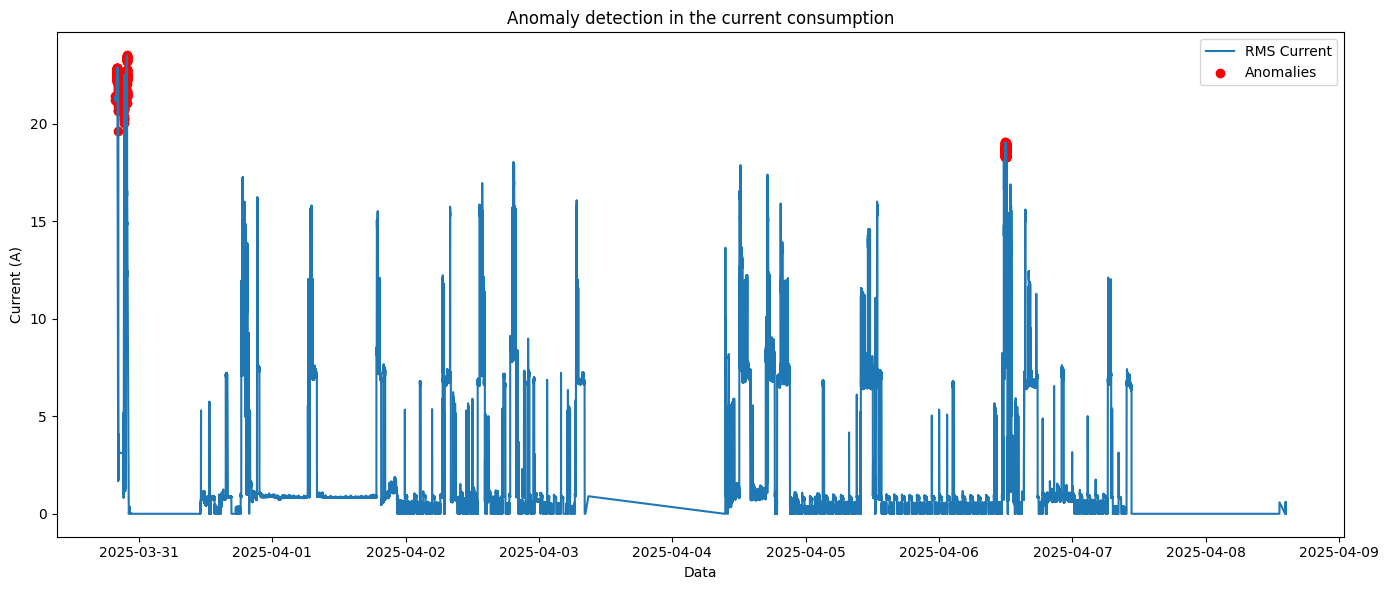

✅ Model e scaler saved.


In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# query the database
DB_PATH = 'deepwatt.db'
conn = sqlite3.connect(DB_PATH)

query = """
SELECT timestamp, rms_current
FROM device_readings
WHERE rms_current IS NOT NULL AND device_id= 'board-cc:50:e3:60:e6:80'
ORDER BY timestamp ASC
"""
df = pd.read_sql_query(query, conn)
conn.close()

# convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('datetime', inplace=True)

# remove some extreme outliers ( > 200 A) 
df = df[(df['rms_current'] >= 0) & (df['rms_current'] < 200)]

# Opcional: aplicar média móvel (suavização)
# df['rms_current'] = df['rms_current'].rolling(window=3, center=True).mean().dropna()

# normalize the data
scaler = StandardScaler()
df['current_scaled'] = scaler.fit_transform(df[['rms_current']])

# train the model
model = IsolationForest(n_estimators=100, contamination=0.002, random_state=42) # the smaller the contamination, less points will be considered an anomaly
model.fit(df[['current_scaled']])

# test with the same training data
df['anomaly'] = model.predict(df[['current_scaled']])  # -1 = anomaly, 1 = normal

# Visualize
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['rms_current'], label='RMS Current')
plt.scatter(df[df['anomaly'] == -1].index,
            df[df['anomaly'] == -1]['rms_current'],
            color='red', label='Anomalies')
plt.legend()
plt.title("Anomaly detection in the current consumption")
plt.xlabel("Data")
plt.ylabel("Current (A)")
plt.tight_layout()
plt.show()

# Save the model and the scale
joblib.dump(model, 'anomaly_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model e scaler saved.")
